# Query Expansion  (Advanced RAG technique)

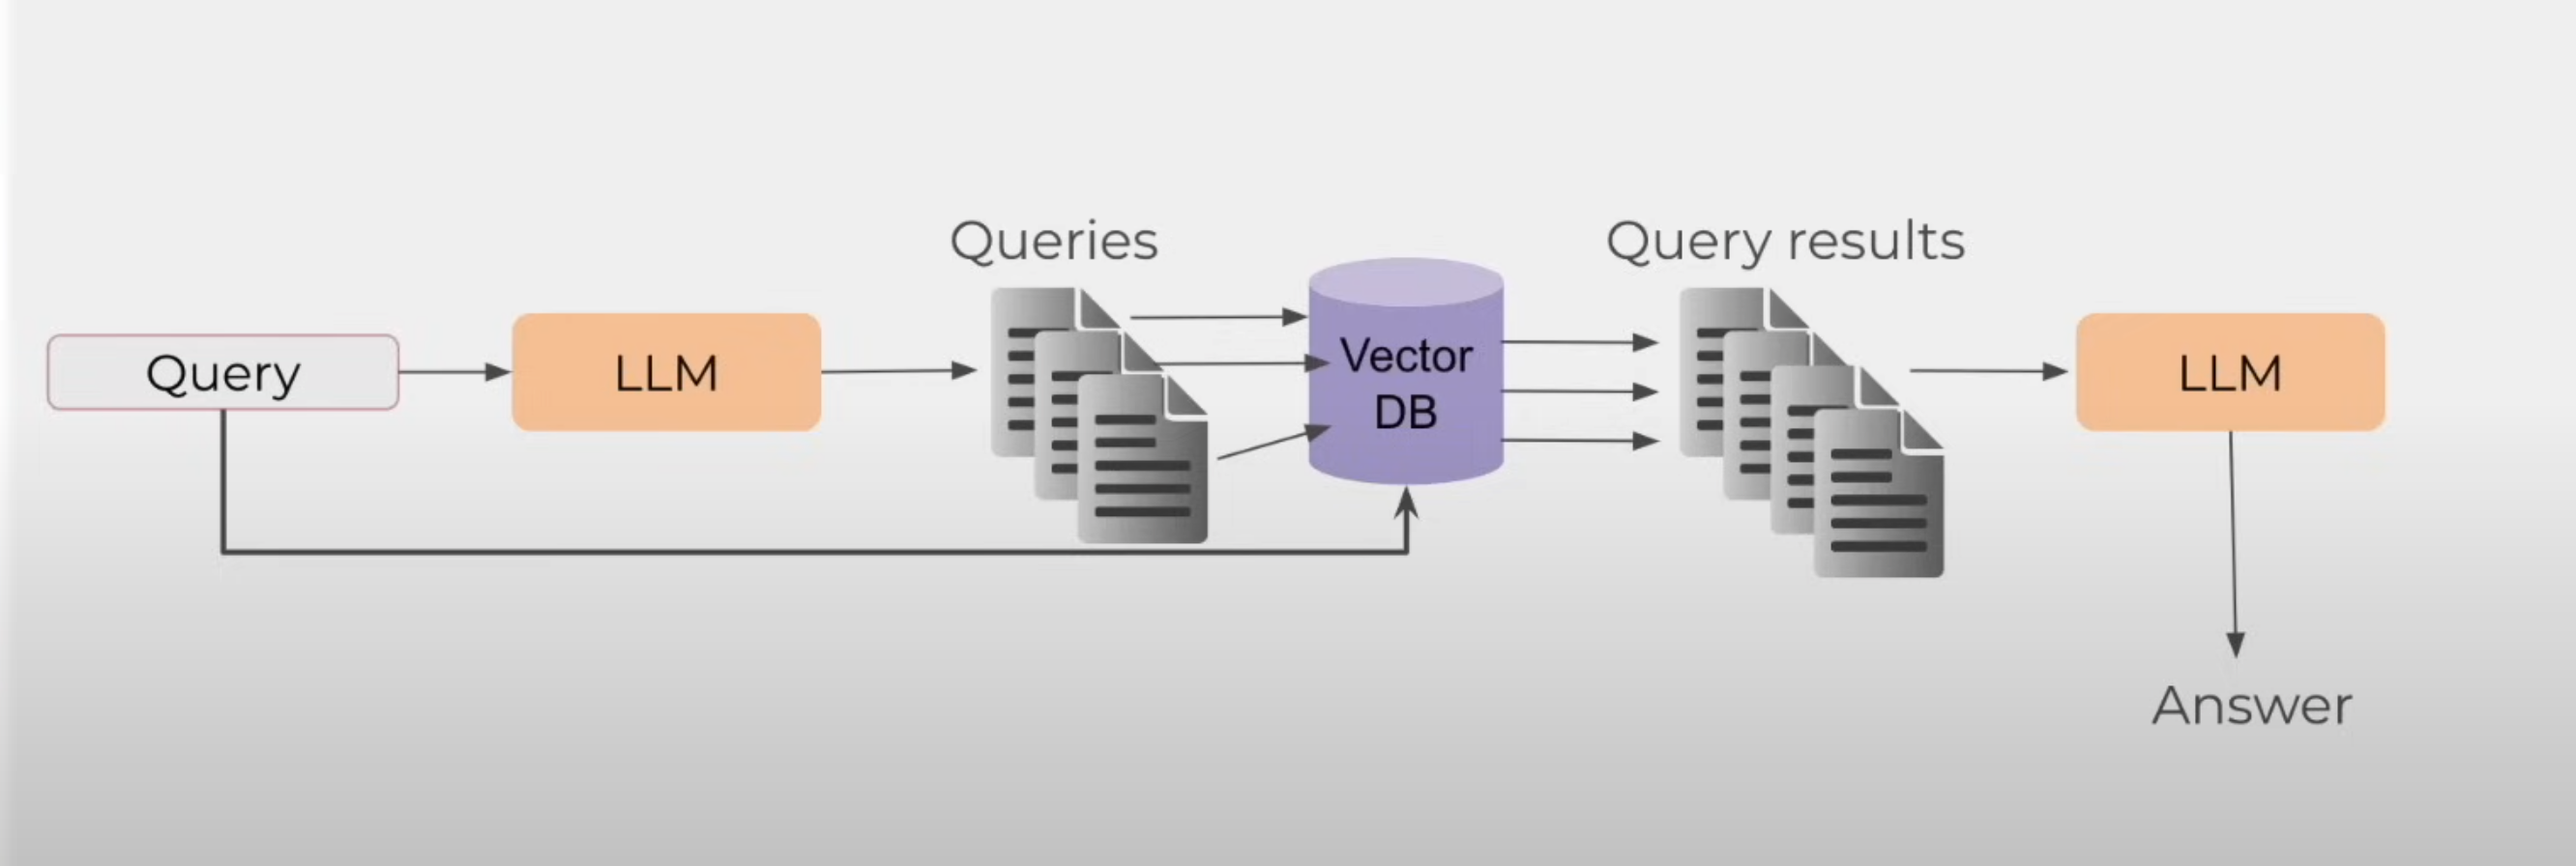

In [1]:
from pypdf import PdfReader
import os
from openai import OpenAI
from dotenv import load_dotenv

**laod the enviroment of openAI**


In [2]:
# Load environment variables from .env file
load_dotenv()
openai_key = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=openai_key)

# Step 1: Read all PDFs in the folder


In [10]:
# Folder containing PDFs
pdf_folder = "documents"

# List all PDFs in the folder
pdf_files = [f for f in os.listdir(pdf_folder) if f.endswith(".pdf")]

# Extract text from all PDFs
pdf_texts = []


In [11]:
for pdf_file in pdf_files:
    pdf_path = os.path.join(pdf_folder, pdf_file)
    reader = PdfReader(pdf_path)

    # Extract text from all pages and filter out empty strings
    pdf_texts.extend([p.extract_text().strip() for p in reader.pages if p.extract_text()])


In [13]:
#This will show you all the PDFs inside "data" so you know which one to inspect.

pdf_folder = "documents"
pdf_files = [f for f in os.listdir(pdf_folder) if f.endswith(".pdf")]

print("Available PDFs:")
for i, file in enumerate(pdf_files, start=1):
    print(f"{i}. {file}")


Available PDFs:
1. guide-to-the-general-data-protection-regulation-gdpr-1-0.pdf
2. CASL-Model-Language-2014-05.pdf
3. beps-2014-deliverables-information-brief.pdf
4. GAAP_Guide_Sheet_508.pdf
5. A Guide to ESG Standards and Frameworks.pdf
6. 19-0017 (Consumer Privacy ).pdf
7. ESG-101-Guide_Feb2024.pdf
8. california-privacy-rights-act-a-compliance-guide.pdf
9. COMPS-1883.pdf
10. ifrs-issued-standards-2022-part-a.pdf


In [15]:

for pdf_file in pdf_files:
    pdf_path = os.path.join(pdf_folder, pdf_file)
    reader = PdfReader(pdf_path)

    if len(reader.pages) > 0:
        print(f"\n--- First Page of '{pdf_file}' ---\n")
        print(reader.pages[0].extract_text())
    else:
        print(f"\n'{pdf_file}' has no pages or text.")


--- First Page of 'guide-to-the-general-data-protection-regulation-gdpr-1-0.pdf' ---

Guide to the
General Data Protection
Regulation (GDPR)
Data protection

--- First Page of 'CASL-Model-Language-2014-05.pdf' ---

 
 
Canadian Anti-Spam Legislation (CASL) 
MODEL LANGUAGE 
 
The following language is recommended to comply with UBC’s requirements under the CASL. Variations 
of this language are acceptable as long as they comply with the legal requirements. This document 
should be read in conjunction with the Frequently Asked Questions (FAQs). 
 
1. Requests for Express Consent  
Legal requirements: You cannot send someone Commercial Electronic Messages unless you have their 
consent. Requests for express consent must contain the following information: 
 
(a) the specific purpose for which you’re seeking their consent 
(b) the name of the UBC unit seeking consent 
(c) the following contact information for the UBC unit seeking consent (or a link to a website containing 
this information

In [16]:
pdf_texts = [text for text in pdf_texts if text]

In [17]:
# Join all texts into a single document
pdf_text_combined = "\n\n".join(pdf_texts)

# Step 2: Combine text and apply character-level chunking


In [18]:
from langchain.text_splitter import (
    RecursiveCharacterTextSplitter,
    SentenceTransformersTokenTextSplitter,
)

In [20]:
character_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", ". ", " ", ""], chunk_size=1000, chunk_overlap=100
)

# Split text into chunks
chunks = character_splitter.split_text(pdf_text_combined)

print(f"Total Chunks: {len(chunks)}")
print("\nFirst Chunk Preview:\n", chunks[0])

Total Chunks: 1381

First Chunk Preview:
 Guide to the
General Data Protection
Regulation (GDPR)
Data protection


# Step 3: Apply token-based chunking

In [22]:

token_splitter = SentenceTransformersTokenTextSplitter(
    chunk_overlap=20, tokens_per_chunk=256
)
token_split_texts = [
    chunk for text in chunks
    for chunk in token_splitter.split_text(text)
]

/Users/hanouf/Desktop/RAGfirstTry/myenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
# Debugging: Print first few chunks
print(f"Total Character Chunks: {len(chunks)}")
print(f"Total Token Chunks: {len(token_split_texts)}")
print("\nFirst Token-Based Chunk Preview:\n", token_split_texts[0])

Total Character Chunks: 1381
Total Token Chunks: 1391

First Token-Based Chunk Preview:
 guide to the general data protection regulation ( gdpr ) data protection


# Embeddings in ChromaDB


In [24]:
import chromadb
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

In [25]:
# Define embedding function using a pre-trained model
embedding_function = SentenceTransformerEmbeddingFunction(model_name="all-MiniLM-L6-v2")

In [26]:
print(embedding_function([token_split_texts[10]]))

[array([-5.26071750e-02,  7.87316263e-02, -2.13372670e-02,  5.01598045e-03,
        4.27101888e-02,  2.35501621e-02,  7.69746350e-03,  7.17110038e-02,
       -1.04959197e-02,  3.79293747e-02,  4.14574221e-02,  1.27108693e-02,
       -3.08764242e-02,  2.77998354e-02,  2.40014922e-02,  5.01291081e-02,
        2.67950017e-02, -3.22499983e-02, -6.10118806e-02, -3.16437036e-02,
       -3.51412259e-02,  6.59268647e-02,  5.71438223e-02, -4.60028537e-02,
       -6.48551583e-02,  3.20426971e-02,  3.57339233e-02, -1.11601464e-01,
        8.26684944e-03,  2.04540659e-02,  5.26796989e-02,  2.59265900e-02,
        2.20498964e-02,  4.51480560e-02,  2.32937131e-02, -8.39420184e-02,
        9.46872458e-02,  1.88380741e-02,  2.43872162e-02,  1.16938213e-02,
        2.80836932e-02, -7.36416131e-02, -8.18211213e-02,  9.27388389e-03,
       -2.90556811e-02,  7.65395164e-03, -5.95023972e-04, -2.74045505e-02,
       -6.29957616e-02,  2.70646065e-02, -1.31911278e-01, -7.65857920e-02,
        3.48444954e-02, 

In [27]:
# Initialize ChromaDB Persistent Client (ensures data isn't lost)
db_path = "chroma_db"  # Change this to set a custom storage directory
chroma_client = chromadb.PersistentClient(path=db_path)

In [28]:
# Create or get the collection
chroma_collection = chroma_client.get_or_create_collection(
    name="microsoft-collection", embedding_function=embedding_function
)

In [29]:
# Ensure token_split_texts is not empty
if not token_split_texts:
    raise ValueError("No text chunks available for embedding!")


In [30]:
# Generate unique document IDs
ids = [str(i) for i in range(len(token_split_texts))]

In [31]:
# Add documents to ChromaDB collection
chroma_collection.add(
    ids=ids, 
    documents=token_split_texts,
    metadatas=[{"chunk_id": i} for i in range(len(token_split_texts))]  # Optional metadata
)

In [32]:
# Confirm the number of stored embeddings
print(f"Total Chunks Stored in ChromaDB: {chroma_collection.count()}")

Total Chunks Stored in ChromaDB: 1391


In [34]:
# Retrieve one stored document
sample_result = chroma_collection.get(ids=["0"])  # Get first stored chunk
print("\nStored Text Chunk:\n", sample_result["documents"])
print("\nStored Metadata:\n", sample_result["metadatas"])



Stored Text Chunk:
 ['guide to the general data protection regulation ( gdpr ) data protection']

Stored Metadata:
 [{'chunk_id': 0}]


# Query Your ChromaDB Collection

In [35]:
import textwrap

In [79]:
query = "What are the differences between GAAP and IFRS?"

In [80]:
# Retrieve top 5 relevant chunks
results = chroma_collection.query(query_texts=[query], n_results=5)

In [81]:
# Extract retrieved documents and metadata
retrieved_documents = results["documents"][0]
retrieved_metadata = results["metadatas"][0]  # If metadata was stored

In [82]:
if not retrieved_documents:
    print("❌ No relevant results found.")
else:
    print("🔎 ** Top Retrieved Chunks: **\n")
    
    for i, document in enumerate(retrieved_documents):
        print(f"🔹 Result {i+1}  (Chunk ID: {retrieved_metadata[i]['chunk_id']})")
        print(textwrap.fill(document, width=100))  # Wrap text neatly
        print("\n" + "-"*80 + "\n")

🔎 ** Top Retrieved Chunks: **

🔹 Result 1  (Chunk ID: 1383)
ifrs® standards issued at 1 january 2022, reflecting changes not yet required this edition is issued
in three parts part a contains the text of ifrs standards including ias® standards, ifric®
interpretations and sic® interpretations, together with the conceptual framework for financial
reporting ( glossary included ) see also parts b and c of this edition : part b contains the
illustrative examples and implementation guidance that accompany the standards, together with ifrs
practice statements part c contains the bases for conclusions that accompany the standards, the
conceptual framework for financial reporting and ifrs practice statements, together with the
constitution and due process handbook of the ifrs foundation

--------------------------------------------------------------------------------

🔹 Result 2  (Chunk ID: 799)
1 generally accepted accounting principles ( gaap ) guide sheet grant financial management requir
em

# Query Expansion  (Advanced RAG technique)

In [83]:
def augment_query_generated(query, model="gpt-3.5-turbo"):
    """
    Uses GPT to generate an improved search query for better document retrieval.
    """
    prompt = """You are a helpful financial research assistant. 
    Rephrase or expand the given question to improve document search accuracy."""

    messages = [
        {"role": "system", "content": prompt},
        {"role": "user", "content": query},
    ]

    response = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=0.3  # Lower temp for better precision
    )
    
    content = response.choices[0].message.content
    return content

In [85]:
# Original user query
original_query = "What are the differences between GAAP and IFRS?"

In [86]:
# Generate a GPT-augmented query
hypothetical_answer = augment_query_generated(original_query)

In [87]:
# Combine original query + GPT-generated answer
joint_query = f"{original_query} {hypothetical_answer}"

In [88]:
# Print the modified query
print("\n🔹 Augmented Query:\n")
print(textwrap.fill(joint_query, width=100))  # Use textwrap.fill for clean formatting


🔹 Augmented Query:

What are the differences between GAAP and IFRS? What are the key distinctions between Generally
Accepted Accounting Principles (GAAP) and International Financial Reporting Standards (IFRS)?


In [91]:
# Query ChromaDB with the improved query
results = chroma_collection.query(
    query_texts=[joint_query],  
    n_results=5,  
    include=["documents", "embeddings", "metadatas", "distances"]  # Explicitly request embeddings
)


In [92]:
# Extract retrieved documents
retrieved_documents = results["documents"][0]

In [94]:
# Print retrieved chunks
print("\n🔎 **Top Retrieved Chunks:**\n")
for i, doc in enumerate(retrieved_documents):
    print(f"🔹 Result {i+1}:  (Chunk ID: {retrieved_metadata[i]['chunk_id']})")
    print(textwrap.fill(doc, width=100))  # Wrap long text for better readability
    print("\n" + "-"*80 + "\n")


🔎 **Top Retrieved Chunks:**

🔹 Result 1:  (Chunk ID: 1383)
as gaap? what additional accounting methods must be put in place to meet government accounting
standards such as gasb and fasb, whichever is applicable? f what procedural issues should be
considered in a gaap policy? f what are the end of the month procedures to ensure gaap compliance? f
what are the end of the fiscal year procedures to ensure gaap compliance? f how is gaap monitored
internally and by whom? what are the principles of the gaap framework? there are 10 main principles
( shown in figure 1 ), which can help you remember the main mission of gaap. figure 1 : 10 main
principles of the gaap framework principle of regularity the organization ’ s accounting adhered to
the standards of gaap. principle of consistency the organization ’ s accounting practices are
consistent and comparable every reporting period. principle of sincerity the organization ’ s
accounting is accurate and correct depic - tion of the financials. pr

idk i just feel they are same thing 

# performing UMAP dimensionality reduction

to visualize how embeddings are structured in vector space. This is useful for understanding how well queries and documents align.

In [95]:
import numpy as np
import umap.umap_ as umap

In [96]:
# Retrieve stored embeddings from ChromaDB
embeddings = chroma_collection.get(include=["embeddings"])["embeddings"]

In [97]:
# Ensure embeddings are in the correct format
embeddings = np.array(embeddings)  # Convert to NumPy array if needed

In [98]:
# Apply UMAP dimensionality reduction
umap_transform = umap.UMAP(n_components=2, random_state=0, transform_seed=0).fit(embeddings)

/Users/hanouf/Desktop/RAGfirstTry/myenv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/hanouf/Desktop/RAGfirstTry/myenv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [99]:
# Function to project embeddings
def project_embeddings(embeddings, umap_model):
    """Projects high-dimensional embeddings into a 2D space using UMAP."""
    return umap_model.transform(np.array(embeddings))

In [100]:
# Project dataset embeddings
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

/Users/hanouf/Desktop/RAGfirstTry/myenv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [101]:
# Retrieve the embeddings for the retrieved chunks
retrieved_embeddings = np.array(results["embeddings"][0])

In [102]:
# Compute embeddings for the queries
original_query_embedding = np.array(embedding_function([original_query]))
augmented_query_embedding = np.array(embedding_function([joint_query]))

In [103]:
# Project queries into the same space
projected_original_query_embedding = project_embeddings(original_query_embedding, umap_transform)
projected_augmented_query_embedding = project_embeddings(augmented_query_embedding, umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

print("✅ UMAP projection completed successfully!")

/Users/hanouf/Desktop/RAGfirstTry/myenv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/hanouf/Desktop/RAGfirstTry/myenv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/hanouf/Desktop/RAGfirstTry/myenv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ UMAP projection completed successfully!


# Visualize Embeddings

In [104]:
import matplotlib.pyplot as plt

In [105]:
print(f"Dataset Embeddings Shape: {projected_dataset_embeddings.shape}")
print(f"Retrieved Embeddings Shape: {projected_retrieved_embeddings.shape}")
print(f"Original Query Shape: {projected_original_query_embedding.shape}")
print(f"Augmented Query Shape: {projected_augmented_query_embedding.shape}")


Dataset Embeddings Shape: (1391, 2)
Retrieved Embeddings Shape: (5, 2)
Original Query Shape: (1, 2)
Augmented Query Shape: (1, 2)


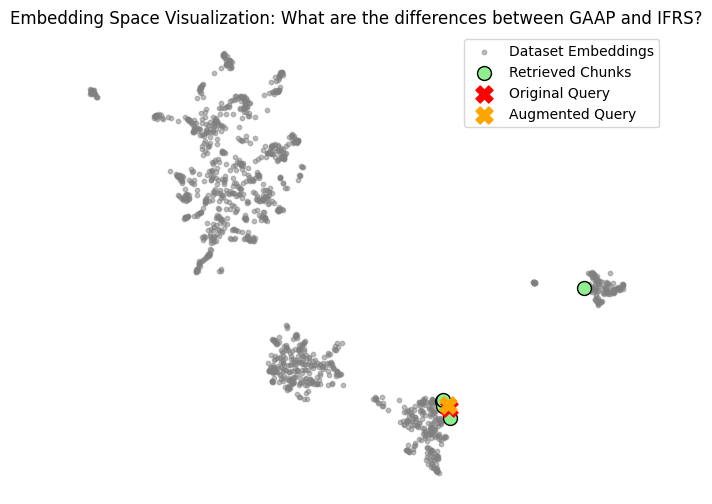

In [106]:

# Create plot
plt.figure(figsize=(8, 6))

# Dataset embeddings (gray background points)
plt.scatter(
    projected_dataset_embeddings[:, 0],
    projected_dataset_embeddings[:, 1],
    s=10,
    color="gray",
    alpha=0.5,
    label="Dataset Embeddings",
)

# Retrieved embeddings (green circles)
plt.scatter(
    projected_retrieved_embeddings[:, 0],
    projected_retrieved_embeddings[:, 1],
    s=100,
    color="lightgreen",
    edgecolors="black",
    label="Retrieved Chunks",
)

# Original query (red X)
plt.scatter(
    projected_original_query_embedding[:, 0],
    projected_original_query_embedding[:, 1],
    s=150,
    marker="X",
    color="red",
    label="Original Query",
)

# Augmented query (orange X)
plt.scatter(
    projected_augmented_query_embedding[:, 0],
    projected_augmented_query_embedding[:, 1],
    s=150,
    marker="X",
    color="orange",
    label="Augmented Query",
)

# Improve readability
plt.gca().set_aspect("equal", "datalim")
plt.title(f"Embedding Space Visualization: {original_query}")
plt.axis("off")  # Hide axis for cleaner visualization
plt.legend()  # Add legend for labels

# Show the plot
plt.show()

ommmmggg

yeah they are not that diff from each other because see the data they are a little far from the other data beacuse it's about ESG not financial 